# Unsupervised learning algorithms

Here I have implemeted a compilation of clustering algorithms, most of them taken from: 

In [2]:
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import umap
from sklearn.manifold import TSNE

## Creating dummy data

<AxesSubplot:xlabel='x', ylabel='y'>

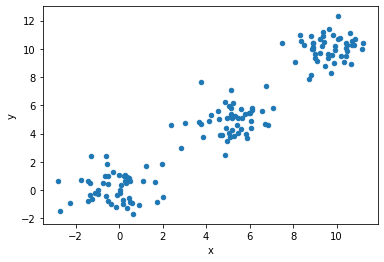

In [3]:
clus1 = np.random.multivariate_normal(mean=[0,0],cov=[[1,0],[0,1]], size= 50)
clus2 = np.random.multivariate_normal(mean=[5,5],cov=[[1,0],[0,1]], size= 50)
clus3 = np.random.multivariate_normal(mean=[10,10],cov=[[1,0],[0,1]], size= 50)
dummy= pd.DataFrame(np.concatenate((clus1,clus2,clus3)), columns=['x','y'])
dummy.plot.scatter(x='x',y='y')

In [4]:
dummy.head()

,x,y
0,1.644978,0.598632
1,-0.569464,1.873678
2,-1.737618,0.726199
3,-0.591978,2.427444
4,0.156120,-0.733929


## Splitting data into 3

In [5]:
def split(data):
    train= data.sample(frac=0.8)
    val= data.drop(train.index)
    test= train.sample(frac=0.25)
    train= train.drop(test.index)
    return (train,test,val)

aux=split(dummy)

## Normalization

In [6]:
def normalize(df):
    return (df-df.mean())/(df.max()-df.min())

normalize(dummy)

,x,y
0,-0.229696,-0.317730
1,-0.387900,-0.226560
2,-0.471355,-0.308608
3,-0.389508,-0.186964
4,-0.336063,-0.413012
...,...,...
145,0.290602,0.381831
146,0.312138,0.406391
147,0.342923,0.455579
148,0.347965,0.233156


## A couple of distances

In [7]:
#euclidean
def eucli(p1,p2,data):
    d=0
    for i in p1.index: #so that it works on n dimentions.
        d+=(p1[i]-p2[i])**2
    return np.sqrt(d)

In [8]:
#mahalonobis
def mahala(p1,p2,data):
    cova= data.cov()
    invcov= pd.DataFrame(np.linalg.pinv(cova.values), cova.columns, cova.index)
    subs= p1-p2
    return subs.dot(invcov).dot(subs.T)

#example of use: mahala(dummy.iloc[0],dummy.iloc[1],dummy)

In [9]:
#manhattan
def manhat(p1,p2,data):
    d=0
    for i in p1.index: #so that it works on n dimentions.
        d+=abs(p1[i]-p2[i])
    return d

## Clustering techniques from (Hammouda,2000)

### Clustering

Here we follow the regular k-means clustering algorithm with the initial set of centroids taken as input. K-means, mountain, substractive and our clustering method all follow this presidure after selecting the initial centroids in their own way.

In [10]:
def cluster(df,c,k,dist,maxiter):
    #0)initialize variables
    Z= 10**15
    n= df.shape[0]  
    #1) Initial centroids are chosen by other algorithms.
    for l in range(maxiter):
        #2)memebership matrix and cost function
        uaux= [-1 for i in range(n)]
        u= pd.DataFrame([uaux for i in range(k)]).T
        J=0
        for i in range(n):
            distances=[0]*k
            for j in range(k):
                #print('i= '+str(i))
                #print('j= '+str(j))
                d=dist(df.loc[i],c.loc[j],df)
                distances[j]= d
            m= min(distances)
            J+=m #put distance of cluster x_i belongs to into cost function (x_i belongs to the 
            #cluster who's centroid it has closest.)
            u.loc[i] = [1 if distances[i]==m else 0 for i in range(k)] # 1 for the cluster represented 
            #by the closest centroid and 0 for the others.

        # 3) See if stop criteria is met
        print(Z)
        if abs(J-Z)/J<0.01:#((abs(J-Z)/J<0.01) or (J>Z)):
            df['label']= u.idxmax(axis=1)
            print(J)
            print(l) #uncomment if you wanna see the number of iterations before reaching end criteria
            return (df,c)
        else: Z=J
            
        # 4) Recalculate the centroids before iterating again
        df['label']= u.idxmax(axis=1)
        c= df.groupby('label').mean()
        if c.shape[0]!=k: k=c.shape[0]
        #print(c)
        df= df.drop('label',axis=1)
    df['label']= u.idxmax(axis=1)
    print(J)
    return (df,c)

### Kmeans

1000000000000000
426.15912501839307
231.09067458547386
231.09067458547386
2


<AxesSubplot:xlabel='x', ylabel='y'>

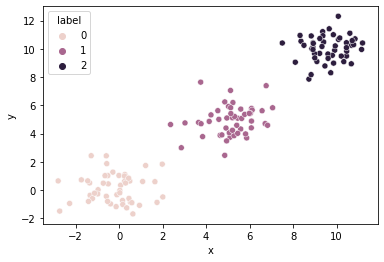

In [11]:
def k(df,k,dist,maxiter): #dist one of 'euclidean','mahalanobis' or 'manhattan'
    df= df.copy().reset_index(drop=True)   
    #1)initial centroids
    c= df.sample(n=k).reset_index(drop=True)   
    (df,c) = cluster(df,c,k,dist,maxiter)
    return df,c

kmeaneados,c=k(dummy,3,manhat,100)
sns.scatterplot(data=kmeaneados, x="x", y="y", hue="label")

### Fuzzy C-means 

This one is interesting because it doesn't use the same process as the rest. Here we calculate an initial membership matrix and from it we find clusters. The other algorithms do it the other way around.

<AxesSubplot:xlabel='x', ylabel='y'>

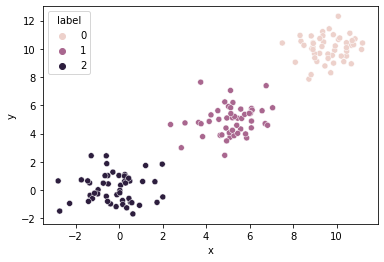

In [12]:
def fcm(df,k,dist,maxiter): #dist is one of 'euclidean','mahalanobis' or 'manhattan'
    #0)initialize variables
    Z= 10**15
    n= df.shape[0]  
    df= df.copy().reset_index(drop=True)
    m=1.5
    #1)initial membership functions
    u=[[] for i in range(n)]
    for i in range(n):
        a = np.random.random(k)
        a /= a.sum()
        u[i]=a
    u= pd.DataFrame(u)
    #2)centroids and cost function
    for l in range(maxiter):
        c=pd.DataFrame([],columns=list(df.columns))
        for i in range(k):
            den= (u[i]**m).sum()
            num= pd.Series([0]*len(df.columns),index=df.columns)
            for j in range(150):
                num=num+(u.at[j,i]**m)*df.loc[j]
            c.loc[i]= num/den
        J=0
        distances= pd.DataFrame([],columns=list(range(k)))
        for i in range(n):
            daux=[0]*k
            for j in range(k):
                #print(c.loc[j])
                d=dist(df.loc[i],c.loc[j],df)
                daux[j]= d
                J+=(u.at[i,j]**m)*(d**2) #put distance into cost function
            distances.loc[i]=daux

            # 3) See if stop criteria is met
        #print(Z)
        if abs(J-Z)/Z<0.01:#((abs(J-Z)/Z<0.01) or (J<3)):
            df['label']= u.idxmax(axis=1)
            #print(J)
            #print(l) #uncomment if you wanna see the number of iterations before reaching end criteria
            return (df,c)
        else: Z=J
        # 4) Recalculate U before iterating again
        for i in range(k):
            for j in range(n):
                u.at[j,i]=0
                for o in range(k):
                    u.at[j,i]+=(distances.at[j,i]/distances.at[j,o])**(2/(m-1))
                u.at[j,i]=u.at[j,i]**(-1)
#         if u.isnull().sum().sum()>0:
#             df['label']= u.idxmax(axis=1)
#             return (df,c)
    df['label']= u.idxmax(axis=1)
    print(J)
    return (df,c)

fuzzy,c=fcm(dummy,3,eucli,100) #
sns.scatterplot(data=fuzzy, x="x", y="y", hue="label")

### Mountain

In [74]:
def mount(df,k,dist,maxiter,sig=1.2,beta=1.2):
    den=3 #measure of grid density. For example, den=3 means that there are 3 possible 
    #values per veriable, creating a grid with 3**m points with m being the number of
    #variebles in the data
    #0) Initialize variables
    #sig=1.2
    #beta=1.2
    n,l=df.shape
    df= df.copy().reset_index(drop=True)
    # 1)Look for initial centroids
    if l==2:
        df.columns=['x','y']
        c=pd.DataFrame([],columns=['x','y'])
    else:
        df.columns=['x','y','z']
        c=pd.DataFrame([],columns=['x','y','z'])        
    tiles = [(1/den)*i-(0.5/den) for i in range(1,den+1)]
    #We will make DF containing the points separated by a column per variable
    gp= [[tiles[j]*(df[i].max()-df[i].min())+df[i].min() for j in range(den)] for i in df.columns]
    gp= pd.DataFrame(gp).T#,columns=range(den)
    gp.columns=df.columns
    #Here we list the points in the grid
    if l==2:
        grid= pd.DataFrame(list(product(gp['x'], gp['y'])),columns=['x','y'])
    else:
        grid= pd.DataFrame(list(product(gp['x'], gp['y'], gp['z'])),columns=['x','y','z'])
    gs= grid.shape[0]#amount of points in the grid
    m=[0]*gs
    for v in range(gs): # Here we find the initial values of mountain functions
        for i in range(n):
            m[v]+= np.exp(-(dist(grid.loc[v],df.loc[i],df)**2)/(2*sig**2))
    c.loc[0]= grid.loc[m.index(max(m))]
    #Here we find the rest of the centroids
    for i in range(1,k):
        for v in range(gs):
            m[v]= m[v]-max(m)*np.exp(-(dist(grid.loc[v],c.iloc[-1],grid)**2)/(2*beta**2))
        c.loc[i]= grid.loc[m.index(max(m))]
    #finally, we cluster. This should convert quicker than the other algorithms because 
    #of well chosen initial centroids.
    print(c)
    df,c= cluster(df,c,k,dist,maxiter)
    return df,c

#mount(normalize(umaptrain3D),5,manhat,100)

          x         y         z
0  0.084439  0.081841 -0.113638
1  0.417772  0.415174  0.219696
2 -0.248895 -0.251493  0.219696
3  0.417772 -0.251493  0.219696
4  0.417772 -0.251493  0.219696
1000000000000000
845.6371444999063
625.1460114978254
618.2176417380106
619.8923835996538
3


(             x         y         z  label
 0     0.219411  0.432428 -0.042245      1
 1    -0.102925 -0.022424 -0.072309      0
 2     0.070782  0.097156 -0.578766      0
 3    -0.277451 -0.230542  0.296925      2
 4    -0.306340 -0.015794 -0.071748      0
 ...        ...       ...       ...    ...
 2256  0.134054  0.228161  0.103842      1
 2257  0.033309 -0.092820 -0.347694      0
 2258  0.159145  0.263659  0.068776      1
 2259  0.026446 -0.059197 -0.500000      0
 2260  0.061194  0.131662  0.095776      0
 
 [2261 rows x 4 columns],
               x         y         z
 label                              
 0     -0.020844  0.037801 -0.119017
 1      0.198827  0.396975  0.014918
 2     -0.270572 -0.178240  0.192079
 3      0.440676 -0.050542 -0.047612)

### Subtractive

1000000000000000
486.0586614443519
408.63298227979556
407.5805940468808
2


<AxesSubplot:xlabel='x', ylabel='y'>

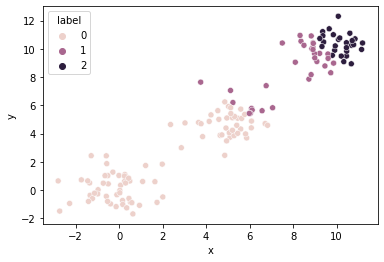

In [18]:
def sub(df,k,dist,maxiter,ra=1.5,rb=1.5):
    
    n=df.shape[0]
    df= df.copy().reset_index(drop=True)
    dm=pd.DataFrame(0.0, index=df.index, columns=df.index) #Distance matrix
    for i in range(n):
        for j in range(n):
            dm[i][j]= np.exp(-(dist(df.loc[i],df.loc[j],df)**2/(ra/2)**2))#
    dm['density']= dm.sum(axis=1)
    
    #select centroids:
    c= pd.DataFrame(0.0,index=range(k),columns=df.columns)
    for ki in range(k):
        nc= dm['density'].idxmax() #index new centroid
        c.loc[ki]= df.loc[nc]
        for i in range(n):
            dm.density[i] = dm.density[i]-dm.density[nc]*np.exp(-(dist(df.loc[i],c.loc[ki],df)**2/(rb/2)**2))
    
    df,c= cluster(df,c,k,dist,maxiter)
    return df,c

s,c=sub(dummy,3,eucli,100)
sns.scatterplot(data=s, x="x", y="y", hue="label")

## Initial centroids by percentiles


1000000000000000
182.6801583655659
182.02261783580843
1


<AxesSubplot:xlabel='x', ylabel='y'>

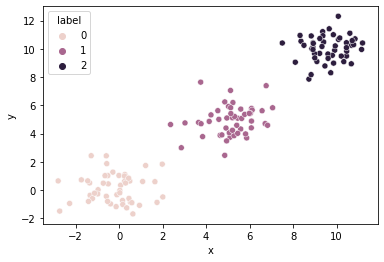

In [15]:
def per(df,k,dist,maxiter):
    df=df.copy().reset_index(drop=True)
    tiles = [(1/k)*i-(0.5/k) for i in range(1,k+1)] #percentiles I want for each centroid
    c=df.quantile(tiles)
    c.index=range(k)
    (df,c)= cluster(df,c,k,dist,maxiter)
    return (df,c)

(perc,c)=per(dummy,3,eucli,100)
sns.scatterplot(data=perc, x="x", y="y", hue="label")

## Now with real data

Before we start, ance we have trained model, we want to be able to use it to label new data. In order to do this, we create the following predict function:

In [19]:
def predict(df,c,dist):
    n= df.shape[0]
    k= c.shape[0]
    df= normalize(df.copy()).reset_index(drop=True)
    uaux= [-1 for i in range(n)]
    u= pd.DataFrame([uaux for i in range(k)]).T
    for i in range(n):
        distances=[0]*k
        for j in range(k):
            d=dist(df.loc[i],c.loc[j],df)
            distances[j]= d
        m= min(distances)
        u.loc[i] = [1 if distances[i]==m else 0 for i in range(k)] # 1 for the cluster represented 
    df['label']= u.idxmax(axis=1)
    return df

#predict(X_test,ct1,eucli)

### The data:

In [20]:
songs= pd.read_excel('dataSong.xlsx')
songs.head()

,index,name,id,num_recomendations,youtube,ytTitle,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,channelId,subscriberCount,hiddenSubscriberCount,videoCount,date,Days Since Publicaiton,chviewCount
0,0.0,La Parranda,0pHebxvuTFdeM4zAM2vwou,2.0,RlBA0ZJnfXI,La Parranda,836499.0,10165.0,573.0,0.0,1.0,UCy86NQba0zXOqWvV6hpZmVA,268000.0,False,151.0,2021-05-19T10:39:58Z,112.0,120509767.0
1,1.0,Amor en Coma,0kRU83ecI57Iw1kPTeUwK5,4.0,wA19OZLAl6M,Amor en Coma,7322773.0,46570.0,3181.0,0.0,1.0,UCfh2j2Dq-aSeLhzuPOsnhVg,2000.0,False,45.0,2021-04-08T10:17:51Z,153.0,398670362.0
2,2.0,Siempre Fine,1C91EF0FrgTMat91LnsiUh,2.0,tANrvswB99w,Siempre Fine,1830713.0,11860.0,813.0,0.0,0.0,UCozx_RfoKiD5puHVTALTLng,14300.0,False,51.0,2021-03-18T15:53:59Z,174.0,19978709.0
3,3.0,Pikete,0BQGWLqUSWCRtFWnBFMONp,1.0,ublxkYXvNV0,Pikete,820327.0,7719.0,769.0,0.0,0.0,UCMJ705HLB_EflTzWDAjcKSQ,126000.0,False,376.0,2021-05-27T10:00:22Z,104.0,351509400.0
4,4.0,Pedrito Pica Piedras,5cgkM5oUoBM79V0zFaJfa1,1.0,unnE7OfPLtQ,Pedrito Pica Piedras,784640.0,11673.0,771.0,0.0,2.0,UCCR73XqynOvqaEdaKZ0a6hg,46.0,False,116.0,2021-01-13T07:01:23Z,238.0,4782620.0


We do some clean up. We get rid of some redundant columns and change the name column to the number of words in the title, as to see if the lenght of the name has any influence.

In [21]:
songs.dropna(inplace=True)
songs['index']=songs['index'].astype('int32')
songs.set_index('index',inplace=True)
songs.drop(['id','youtube','ytTitle','date','hiddenSubscriberCount','channelId','favoriteCount'],axis=1,inplace=True)
songs['name']= songs['name'].str.split().apply(len)
songs.head()

,name,num_recomendations,viewCount,likeCount,dislikeCount,commentCount,subscriberCount,videoCount,Days Since Publicaiton,chviewCount
index,,,,,,,,,,
0,2,2.0,836499.0,10165.0,573.0,1.0,268000.0,151.0,112.0,120509767.0
1,3,4.0,7322773.0,46570.0,3181.0,1.0,2000.0,45.0,153.0,398670362.0
2,2,2.0,1830713.0,11860.0,813.0,0.0,14300.0,51.0,174.0,19978709.0
3,1,1.0,820327.0,7719.0,769.0,0.0,126000.0,376.0,104.0,351509400.0
4,3,1.0,784640.0,11673.0,771.0,2.0,46.0,116.0,238.0,4782620.0


In [22]:
songs.shape

(3769, 10)

### Now we make our train, test, validation splits and normalize the train data.

The rest will only be normalized right before labeling once the models are tarined.

In [23]:
(X_train,X_test,X_Val)= split(songs)

In [24]:
X_train = normalize(X_train)
X_train

,name,num_recomendations,viewCount,likeCount,dislikeCount,commentCount,subscriberCount,videoCount,Days Since Publicaiton,chviewCount
index,,,,,,,,,,
167,-0.060770,-0.03682,-0.017622,-0.029579,-0.023434,-0.006010,-0.004446,-0.007182,-0.103211,-0.032179
2980,0.072564,-0.03682,-0.016662,-0.026896,-0.022574,-0.005157,-0.004457,-0.006681,0.093438,-0.036694
2163,0.005897,-0.03682,-0.018164,-0.028333,-0.023952,-0.006121,-0.001936,0.007632,-0.172562,0.051613
1309,-0.060770,0.21318,-0.015538,-0.020522,-0.012174,-0.005416,-0.003910,-0.007196,0.206540,-0.036992
2167,0.205897,-0.03682,-0.015356,-0.020767,-0.019710,-0.001261,0.000055,-0.005320,-0.078077,-0.022751
...,...,...,...,...,...,...,...,...,...,...
3484,-0.060770,-0.03682,-0.018276,-0.030280,-0.023930,-0.005565,-0.003940,-0.006573,0.030138,-0.037085
711,0.005897,-0.03682,-0.018085,-0.028385,-0.022475,-0.004823,-0.004171,0.014471,0.047825,-0.037143
2834,-0.060770,-0.03682,-0.006766,-0.007277,-0.009079,0.005008,-0.004331,-0.006573,-0.004538,-0.020510


### UMAP

We use this to do dimension reduction. This is useful for plotting.

In [117]:
reducer = umap.UMAP()
umap_train = reducer.fit_transform(X_train)
umap_train.shape

(2261, 2)

Text(0.5, 1.0, 'UMAP projection of Spotify songs')

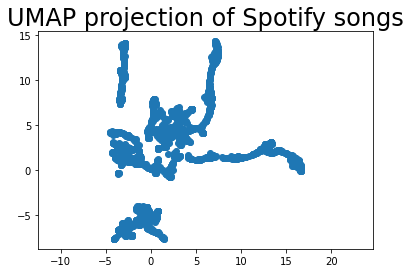

In [118]:
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    )#c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of Spotify songs', fontsize=24)

From seeing this plot, I have arbitrarily decided to always use k=5 in all of our clustering ventures with this data.
![alt text](arbi.jpg "Title")

In [27]:
umaptrain=pd.DataFrame(umap_train, columns=['x','y'])

We repeate this for the test data so we can plot results taken from the predict function

In [112]:
reducer = umap.UMAP()
umap_test = reducer.fit_transform(normalize(X_test))
umap_test.shape

(754, 2)

Text(0.5, 1.0, 'UMAP projection of Spotify songs test set')

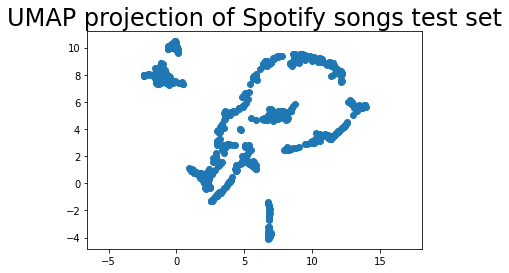

In [113]:
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    )#c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of Spotify songs test set', fontsize=24)

In [30]:
umaptest=pd.DataFrame(umap_test, columns=['x','y'])

### Let's see $R^n$ results

#### k-means

1000000000000000
437.2079027181768
374.2172011848095
363.3442477760584
359.63775862125186
358.3394233716397
4


Text(0.5, 1.0, 'Spotify songs clustered by k-means and Euclidean distance')

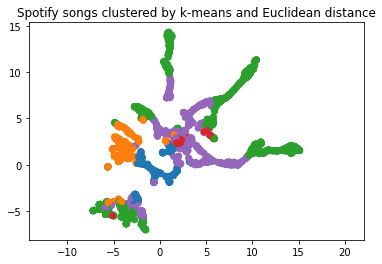

In [31]:
keucli,ck1=k(X_train,5,eucli,100)#umapdf
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in keucli.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by k-means and Euclidean distance', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by k-means and Euclidean distance, test data')

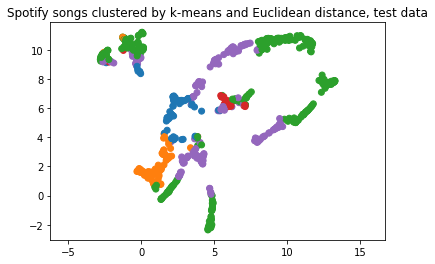

In [32]:
#predict for the test data
keuclitest= predict(X_test,ck1,eucli)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in keuclitest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by k-means and Euclidean distance, test data', fontsize=12)

1000000000000000
20353.880807674363
18105.386100782438
17921.554605334535
17781.708912897597
3


Text(0.5, 1.0, 'Spotify songs clustered by k-means and Mahalanobis distance')

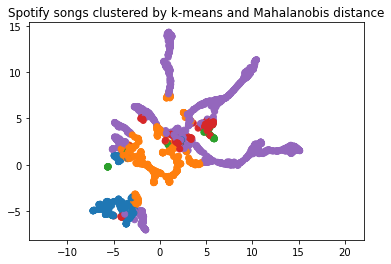

In [33]:
kmahala,ck2=k(X_train,5,mahala,100)#umapdf
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in kmahala.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by k-means and Mahalanobis distance', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by k-means and Mahalanobis distance, test data')

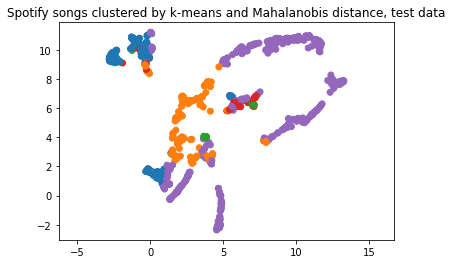

In [34]:
#predict for the test data
kmahalatest= predict(X_test,ck2,mahala)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in kmahalatest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by k-means and Mahalanobis distance, test data', fontsize=12)

1000000000000000
714.743932321063
717.0486103195951
1


Text(0.5, 1.0, 'Spotify songs clustered by k-means and Manhatan distance')

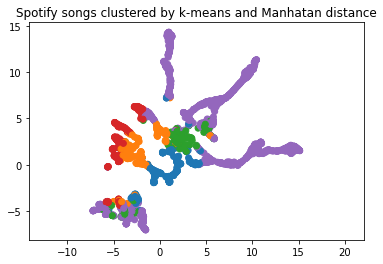

In [35]:
kmanhat,ck3=k(X_train,5,manhat,100)#umapdf
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in kmanhat.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by k-means and Manhatan distance', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by k-means and Manhatan distance, test data')

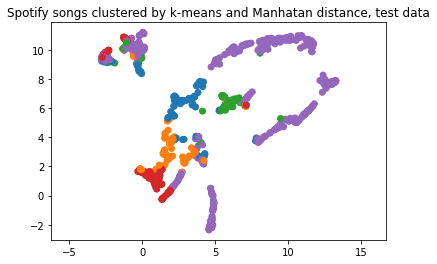

In [36]:
#predict for the test data
kmanhattest= predict(X_test,ck3,manhat)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in kmanhattest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by k-means and Manhatan distance, test data', fontsize=12)

#### Fuzzy C-means

Text(0.5, 1.0, 'Spotify songs clustered by fuzzy c-means and Euclidean distance')

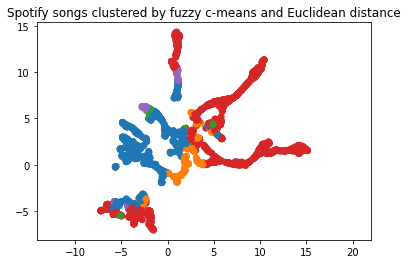

In [37]:
feucli,cf1=fcm(X_train,5,eucli,100)#umapdf
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in feucli.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by fuzzy c-means and Euclidean distance', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by fuzzy c-means and Euclidean distance, test data')

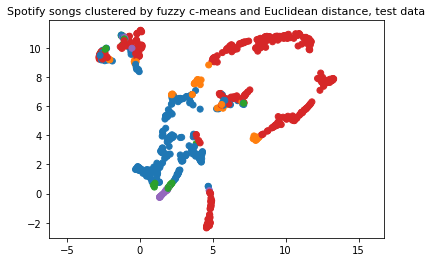

In [38]:
#predict for the test data
feuclitest= predict(X_test,cf1,eucli)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in feuclitest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by fuzzy c-means and Euclidean distance, test data', fontsize=11)

Text(0.5, 1.0, 'Spotify songs clustered by fuzzy c-means and Mahalanobis distance')

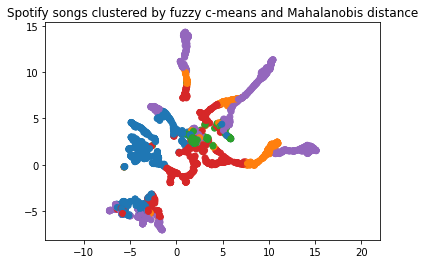

In [39]:
fmahala,cf2=fcm(X_train,5,mahala,100)#umapdf
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in fmahala.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by fuzzy c-means and Mahalanobis distance', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by fuzzy c-means and Mahalanobis distance, test data')

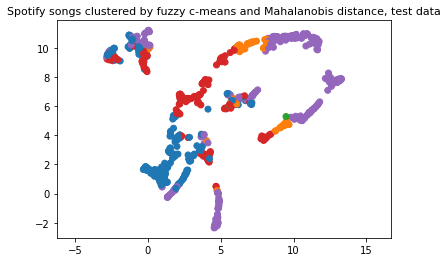

In [40]:
#predict for the test data
fmahalatest= predict(X_test,cf2,mahala)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in fmahalatest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by fuzzy c-means and Mahalanobis distance, test data', fontsize=11)

Text(0.5, 1.0, 'Spotify songs clustered by fuzzy c-means and Manhatan distance')

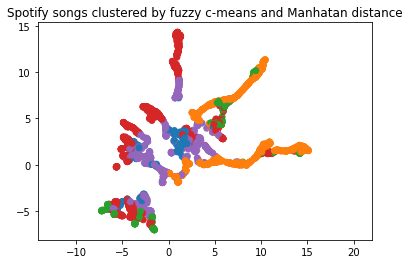

In [41]:
fmanhat,cf3=fcm(X_train,5,manhat,100)#umapdf
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in fmanhat.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by fuzzy c-means and Manhatan distance', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by fuzzy c-means and Manhatan distance, test data')

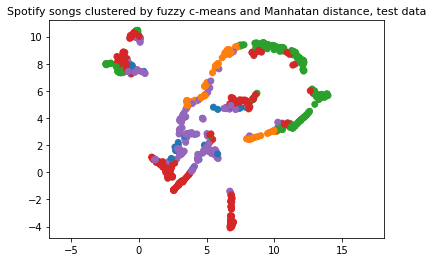

In [119]:
#predict for the test data
fmanhattest= predict(X_test,cf3,manhat)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in fmanhattest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by fuzzy c-means and Manhatan distance, test data', fontsize=11)

### My algorithm

1000000000000000
407.09533730787086
384.51051488675574
371.7035387873483
367.6212418674226
365.05519122104204
4


Text(0.5, 1.0, 'Spotify songs clustered by custom k-means and Euclidean distance')

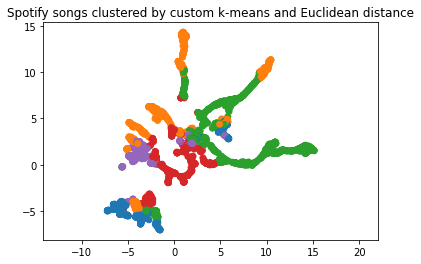

In [43]:
peucli,cp1=per(X_train,5,eucli,100)#umapdf
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in peucli.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by custom k-means and Euclidean distance', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by custom k-means and Euclidean distance, test data')

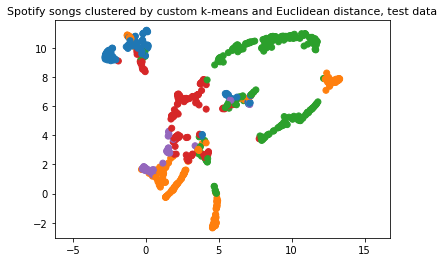

In [44]:
#predict for the test data
peuclitest= predict(X_test,cp1,eucli)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in peuclitest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by custom k-means and Euclidean distance, test data', fontsize=11)

1000000000000000
20739.866908625103
19578.864356680533
19029.70975693354
18708.164798587517
18254.589109375607
17364.53109333361
17105.49873835977
17060.432212181888
7


Text(0.5, 1.0, 'Spotify songs clustered by custom k-means and Mahalanobis distance')

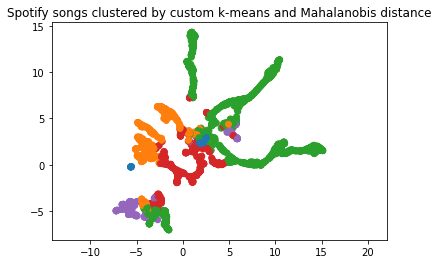

In [45]:
pmahala,cp2=per(X_train,5,mahala,100)#umapdf
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in pmahala.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by custom k-means and Mahalanobis distance', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by custom k-means and Mahalanobis distance, test data')

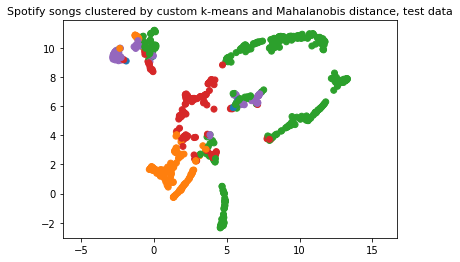

In [46]:
#predict for the test data
pmahalatest= predict(X_test,cp2,mahala)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in pmahalatest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by custom k-means and Mahalanobis distance, test data', fontsize=11)

1000000000000000
682.1423164351412
747.5014238256958
728.1966535350994
729.3019602184224
3


Text(0.5, 1.0, 'Spotify songs clustered by custom k-means and Manhatan distance')

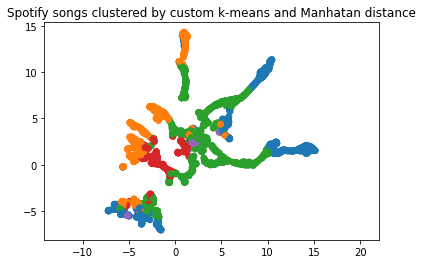

In [47]:
pmanhat,cp3=per(X_train,5,manhat,100)#umapdf
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in pmanhat.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by custom k-means and Manhatan distance', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by fuzzy custom k-means and Manhatan distance, test data')

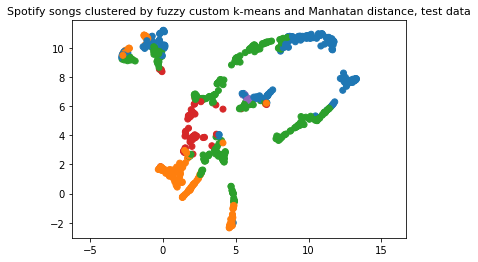

In [48]:
#predict for the test data
pmanhattest= predict(X_test,cp3,manhat)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in pmanhattest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by fuzzy custom k-means and Manhatan distance, test data', fontsize=11)

## Mountain and substractive methods on $R^2$ and $R^3$ spaces

Before we can use these two methods, we must first find values for their respective parameters given the data at hand. In order to do that we will do some parameter sensibility analysis on them in UMAP 2D space and analize the graphs to choose the best parameters. 

          x         y
0  0.086703  0.056581
1  0.420036  0.389914
2  0.420036  0.389914
3  0.420036  0.389914
4  0.420036  0.389914
1000000000000000
663.2001137176194
553.179891332571
516.774879041889
495.33439894264654
491.11795410333843
4


Text(0.5, 1.0, 'Spotify songs clustered by mountain k-means and Euclidean distance')

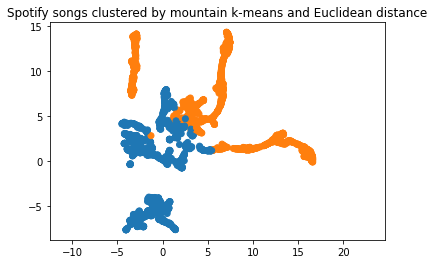

In [124]:
meucli,cm1=mount(normalize(umaptrain),5,eucli,100,sig=1.2,beta=1.2)
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in meucli.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by mountain k-means and Euclidean distance', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by mountain clustering and Euclidean distance, test data')

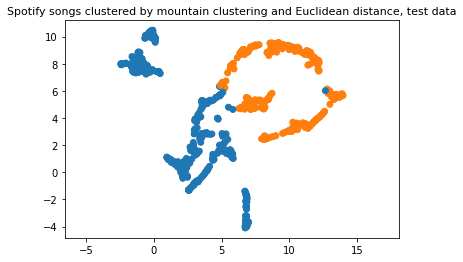

In [125]:
meuclitest= predict(umaptest,cm1,eucli)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in meuclitest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by mountain clustering and Euclidean distance, test data', fontsize=11)

After seeing this result, sigma and beta parameters for mountain will be set at 1.2 for the rest of the runs.

ra and rb will be set at 1.5

          x         y
0  0.086703  0.056581
1 -0.246630 -0.276752
2  0.420036  0.389914
3 -0.246630  0.389914
4  0.420036 -0.276752
1000000000000000
1646.638502979941
965.3060192651768
928.5228802961908
914.3136726528769
908.9999199307341
4


Text(0.5, 1.0, 'Spotify songs clustered by mountain k-means and Mahalanobis distance, test data')

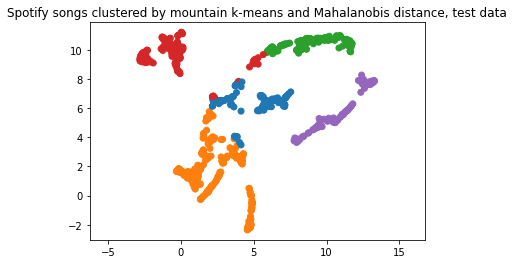

In [50]:
mmahala,cm2=mount(normalize(umaptrain),5,mahala,100)
mmahalatest= predict(umaptest,cm2,mahala)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in mmahalatest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by mountain k-means and Mahalanobis distance, test data', fontsize=12)

Text(0.5, 1.0, 'Spotify songs clustered by substractive clustering and Mahalanobis distance, test data')

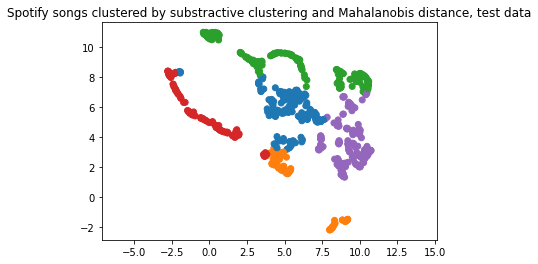

In [134]:
#smahala,cs2=sub(normalize(umaptrain),5,mahala,100)
smahalatest= predict(umaptest,cs2,mahala)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in smahalatest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by substractive clustering and Mahalanobis distance, test data', fontsize=12)


          x         y
0  0.086703  0.056581
1  0.420036  0.389914
2 -0.246630 -0.276752
3 -0.246630 -0.276752
4 -0.246630 -0.276752
1000000000000000
573.387289974131
530.5581936687231
512.9401298193261
506.99399412516505
505.0901210187003
4


Text(0.5, 1.0, 'Spotify songs clustered by mountain k-means and Manhatan distance, test data')

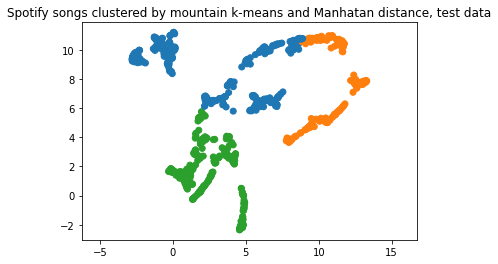

In [51]:
mmanhat,cm3=mount(normalize(umaptrain),5,manhat,100)
mmanhattest= predict(umaptest,cm3,mahala)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in mmanhattest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by mountain k-means and Manhatan distance, test data', fontsize=12)

In [ ]:
smanhat,cs3=sub(normalize(umaptrain),5,manhat,100)
smanhattest= predict(umaptest,cs3,manhat)
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in smanhattest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by substractive clustering and Manhatan distance, test data', fontsize=12)

In [56]:
tsne = TSNE(n_components=2)
tsnetrainembed = tsne.fit_transform(X_train) 
tsnetrain= pd.DataFrame()
tsnetrain["x"] = tsnetrainembed[:,0]
tsnetrain["y"] = tsnetrainembed[:,1]
tsnetrain

,x,y
0,-51.362793,-6.625445
1,7.776465,-1.323563
2,-31.518597,-7.771414
3,5.160983,-37.002274
4,23.206812,-14.774654
...,...,...
2256,-35.715881,11.652990
2257,-17.394802,35.155754
2258,-38.463055,6.909089
2259,-27.168352,42.129211


Text(0.5, 1.0, 'Spotify songs dimension reduction with T-SNE')

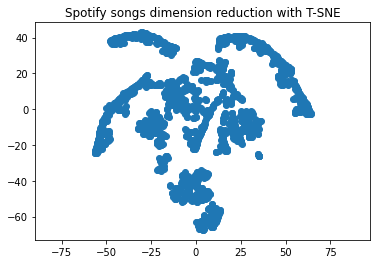

In [57]:
plt.scatter(
    tsnetrainembed[:,0],
    tsnetrainembed[:,1],
    #c=[sns.color_palette()[x] for x in mmanhattest.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs dimension reduction with T-SNE', fontsize=12)

           x          y
0   3.764452  24.548377
1   3.764452 -12.251949
2   3.764452 -49.052275
3  44.010351  24.548377
4 -36.481447 -12.251949
1000000000000000
40689.81696696131
37722.236216864156
37265.91817610952
37176.6619613617
3


Text(0.5, 1.0, 'Spotify songs clustered by mountain clustering and Euclidean distance, tsne reduction')

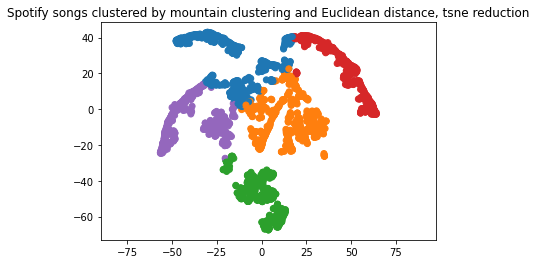

In [127]:
meuclitsne,cm4=mount(tsnetrain,5,eucli,100)
plt.scatter(
    tsnetrainembed[:,0],
    tsnetrainembed[:,1],
    c=[sns.color_palette()[x] for x in meuclitsne.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by mountain clustering and Euclidean distance, tsne reduction', fontsize=12)

           x          y
0   3.764452 -12.251949
1  44.010351  24.548377
2 -36.481447  24.548377
3 -36.481447 -49.052275
4  44.010351 -49.052275
1000000000000000
1699.5679864492745
1229.6597994061578
1041.4434869555448
916.5965182881049
889.703605020967
883.0173832602777
5


Text(0.5, 1.0, 'Spotify songs clustered by mountain clustering and Mahalanobis distance, tsne reduction')

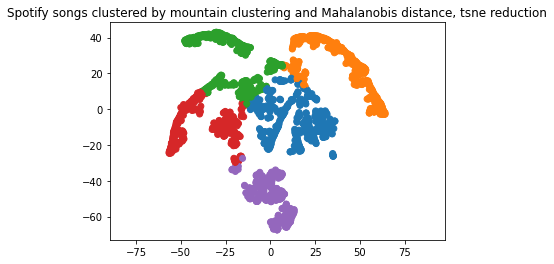

In [59]:
mmahalatsne,cm5=mount(tsnetrain,5,mahala,100)
plt.scatter(
    tsnetrainembed[:,0],
    tsnetrainembed[:,1],
    c=[sns.color_palette()[x] for x in mmahalatsne.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by mountain clustering and Mahalanobis distance, tsne reduction', fontsize=12)

           x          y
0   3.764452  24.548377
1   3.764452 -12.251949
2   3.764452 -49.052275
3  44.010351  24.548377
4 -36.481447 -12.251949
1000000000000000
52337.74635070372
49118.267508126795
48705.059362351894
2


Text(0.5, 1.0, 'Spotify songs clustered by mountain clustering and Manhatan distance, tsne reduction')

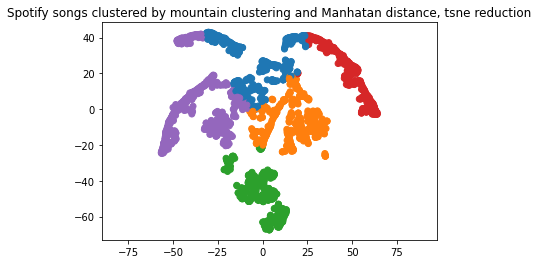

In [60]:
mmanhattsne,cm6=mount(tsnetrain,5,manhat,100)
plt.scatter(
    tsnetrainembed[:,0],
    tsnetrainembed[:,1],
    c=[sns.color_palette()[x] for x in mmanhattsne.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by mountain clustering and Manhatan distance, tsne reduction', fontsize=12)

In [66]:
reducer = umap.UMAP(n_components=3)
umap_train3D = reducer.fit_transform(X_train)

In [67]:
umaptrain3D=pd.DataFrame(umap_train3D, columns=['x','y','z'])
#umaptrain3D

In [68]:
reducer = umap.UMAP(n_components=3)
umap_test3D = reducer.fit_transform(X_test)

In [69]:
umaptest3D=pd.DataFrame(umap_test3D, columns=['x','y','z'])
#umaptest3D

Text(0.5, 0.92, 'Spotify songs clustered by mountain k-means and Euclidean distance, test data in 3D')

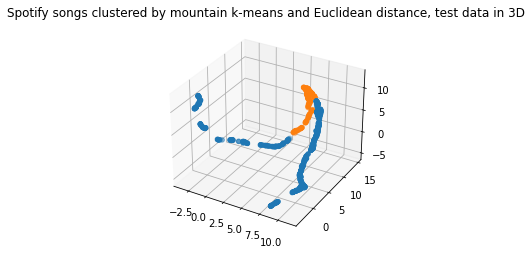

In [81]:
#meucli3D,cme3D=mount(normalize(umaptrain3D),5,eucli,100)
#meuclitest= predict(umaptest3D,cme3D,eucli)
ax = plt.axes(projection='3d')
ax.scatter3D(
    umap_test3D[:, 0],
    umap_test3D[:, 1],
    umap_test3D[:, 2],
    c=[sns.color_palette()[x] for x in meuclitest.label]
    )
#plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by mountain k-means and Euclidean distance, test data in 3D', fontsize=12)

          x         y         z
0  0.084439  0.081841 -0.113638
1 -0.248895 -0.251493  0.219696
2  0.084439  0.081841  0.219696
3 -0.248895  0.081841 -0.113638
4  0.417772  0.415174 -0.113638
1000000000000000
3607.780547060904
2657.169705705197
2371.848286307158
1991.5712150332913
1935.3611596574065
1800.0223715914922
1487.7752028640587
1424.4974863646985
1417.2490187718531
8


Text(0.5, 0.92, 'Spotify songs clustered by mountain k-means and Mahalanobis distance, test data in 3D')

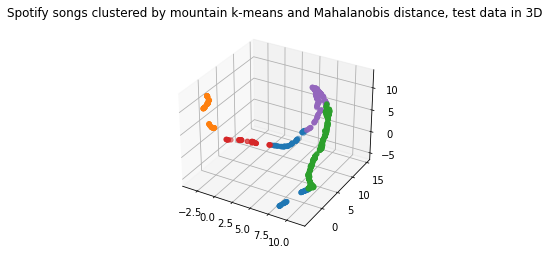

In [82]:
mmahala3D,cmmahala3D=mount(normalize(umaptrain3D),5,mahala,100)
mmahalatest= predict(umaptest3D,cmmahala3D,mahala)
ax = plt.axes(projection='3d')
ax.scatter3D(
    umap_test3D[:, 0],
    umap_test3D[:, 1],
    umap_test3D[:, 2],
    c=[sns.color_palette()[x] for x in mmahalatest.label]
    )
plt.title('Spotify songs clustered by mountain k-means and Mahalanobis distance, test data in 3D', fontsize=12)

          x         y         z
0  0.084439  0.081841 -0.113638
1  0.417772  0.415174  0.219696
2 -0.248895 -0.251493  0.219696
3  0.417772 -0.251493  0.219696
4  0.417772 -0.251493  0.219696
1000000000000000
845.6371444999063
625.1460114978254
618.2176417380106
619.8923835996538
3


Text(0.5, 0.92, 'Spotify songs clustered by mountain k-means and Manhatan distance, test data in 3D')

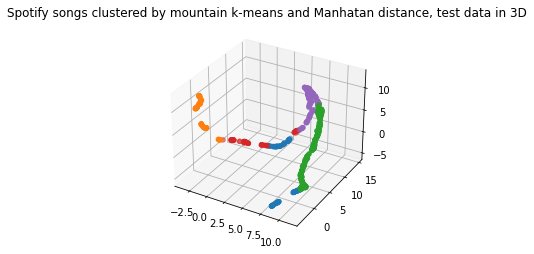

In [83]:
mmanhat3D,cmmanhat3D=mount(normalize(umaptrain3D),5,manhat,100)
mmanhattest= predict(umaptest3D,cmmahala3D,manhat)
ax = plt.axes(projection='3d')
ax.scatter3D(
    umap_test3D[:, 0],
    umap_test3D[:, 1],
    umap_test3D[:, 2],
    c=[sns.color_palette()[x] for x in mmanhattest.label]
    )
plt.title('Spotify songs clustered by mountain k-means and Manhatan distance, test data in 3D', fontsize=12)

In [84]:
X_train.to_excel('X_train.xlsx')
X_test.to_excel('X_test.xlsx')
X_Val.to_excel('Validation_Data.xlsx')

### substractive


In [130]:
cs1

,x,y
label,,
0,2.289659,3.561946
1,10.156267,4.962628
2,4.927205,1.033131
3,-0.990385,7.566820
4,-3.392037,-2.721479


1000000000000000
12172.160877074626
7891.6698252574415
7427.59234329441
7398.249269965414
3


Text(0.5, 1.0, 'Spotify songs clustered by substractive clustering and Euclidean distance')

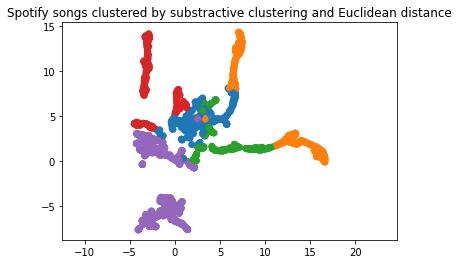

In [129]:
s,cs1=sub(umaptrain,5,eucli,100)
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in s.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by substractive clustering and Euclidean distance', fontsize=12)


1000000000000000
60245.76718093981
43821.16228894646
41890.13324418741
41270.506421910235
40811.99136672069
40337.725886350585
40106.72544876967
6


Text(0.5, 1.0, 'Spotify songs clustered by substractive clustering and Euclidean distance, tsne reduction')

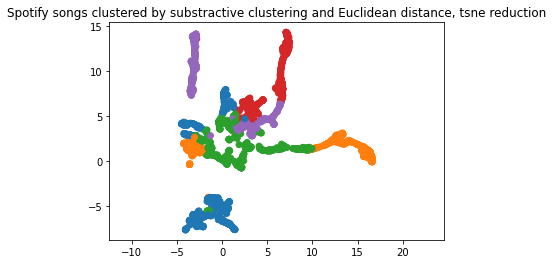

In [131]:
stsne,cs1tsne=sub(tsnetrain,5,eucli,100)
plt.scatter(
    umap_train[:, 0], #change this here
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in stsne.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by substractive clustering and Euclidean distance, tsne reduction', fontsize=12)

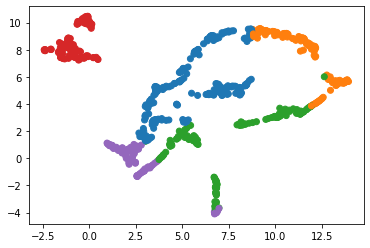

In [136]:
plt.scatter(
    umap_test[:, 0],
    umap_test[:, 1],
    c=[sns.color_palette()[x] for x in predict(umaptest,normalize(cs1),eucli).label]
    )
#predict(umaptest,normalize(cs1),eucli)


1000000000000000
15857.765808032593
9403.202811479568
9022.915125057101
8980.926111839712
3


Text(0.5, 1.0, 'Spotify songs clustered by substractive clustering and Manhatan distance')

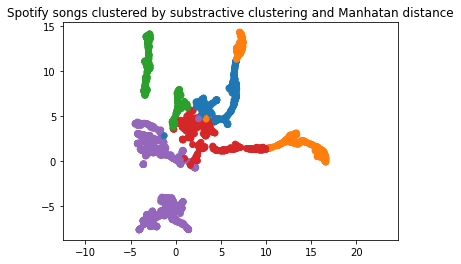

In [137]:
smanhat,cs2=sub(umaptrain,5,manhat,100)
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in smanhat.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by substractive clustering and Manhatan distance', fontsize=12)

1000000000000000
84899.4461153578
65079.4857198596
53330.86825412512
49446.52918331325
48396.58008927107
47786.605295836926
47588.085040688515
6


Text(0.5, 1.0, 'Spotify songs clustered by substractive clustering and Manhatan distance, tsne reduction')

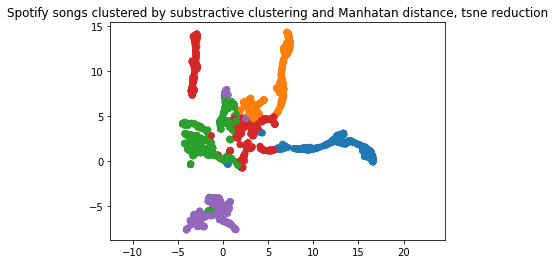

In [138]:
smanhattsne,cs2tsne=sub(tsnetrain,5,manhat,100)
plt.scatter(
    umap_train[:, 0],
    umap_train[:, 1],
    c=[sns.color_palette()[x] for x in smanhattsne.label]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('Spotify songs clustered by substractive clustering and Manhatan distance, tsne reduction', fontsize=12)